# Cross Validation

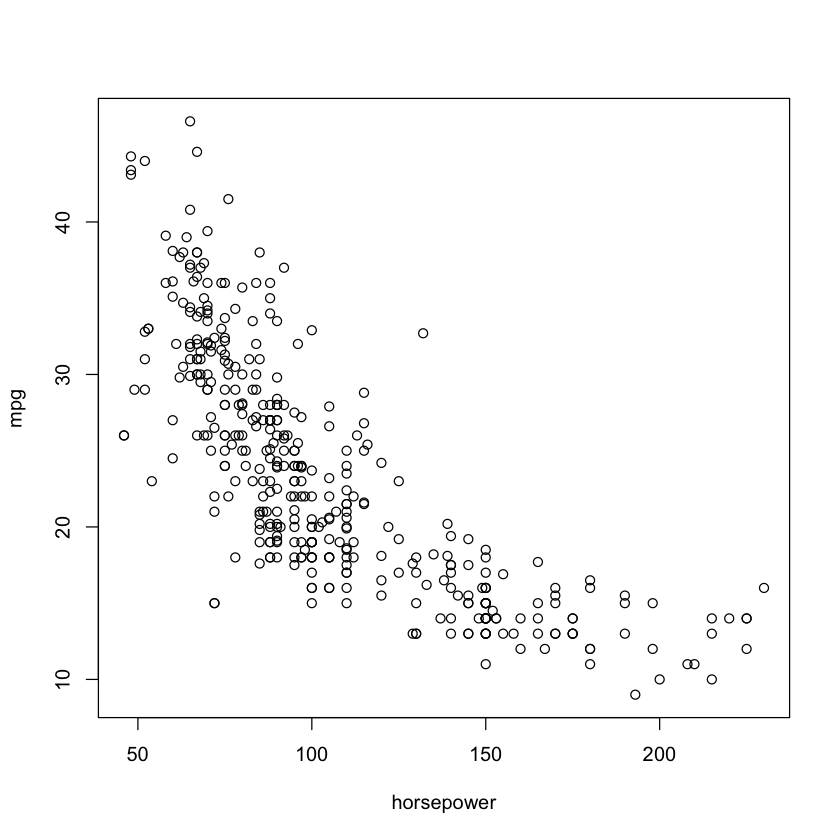

In [1]:
library(ISLR)
library(boot)
library(ggplot2)
library(magrittr)
plot(mpg~horsepower, data=Auto)

### LOOCV

In [2]:
# Brute force LOOCV does not use simple formula for
# linear regression
glm.fit = glm(mpg~horsepower, data=Auto)
# delta: cross validate prediction error
# returns: 
#         *Raw LOOCV result
#         *Bias corrected version of LOOCV
cv.glm(Auto, glm.fit)$delta

[1] 24.23151 24.23114

For linear regression:

$$
   \frac{1}{n}\sum{(y_i - \hat{y}_{-i})^2} = \frac{1}{n}\sum{\frac{(y_i - \hat{y}_{i})^2}{(1 - H_{ii})^2}}
$$

where 
* $\hat{y}_{-i}$ is the predicted model minus the $i$-th element
* $H_{ii}$ is the hat matrix; the operator matrix that produces the least squares fit

In [5]:
loocv = function(fit){
    h = lm.influence(fit)$h
    mean((residuals(fit)/(1-h))^2)
}

loocv(glm.fit)

[1] 24.23151

We will fit various polynomial degrees to Auto and compute the *LOOCV* value

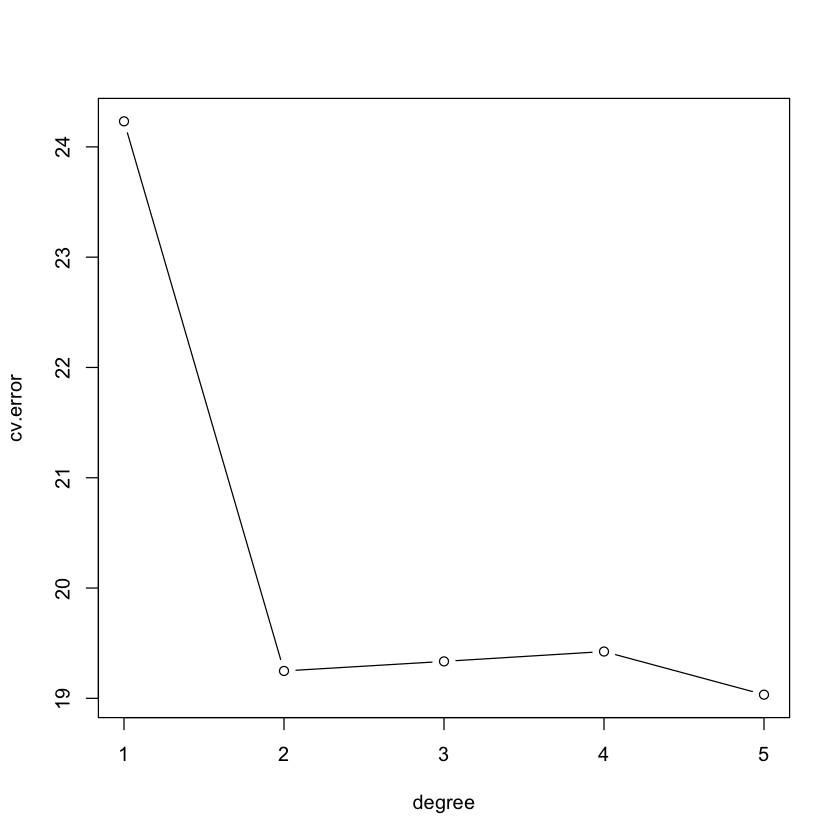

In [9]:
cv.error = rep(0, 5)
degree = 1:5

for(d in degree){
    glm.fit = glm(mpg ~ poly(horsepower, d), data=Auto)
    cv.error[d] = loocv(glm.fit)
}

plot(degree, cv.error, type="b")

### 10-fold CV

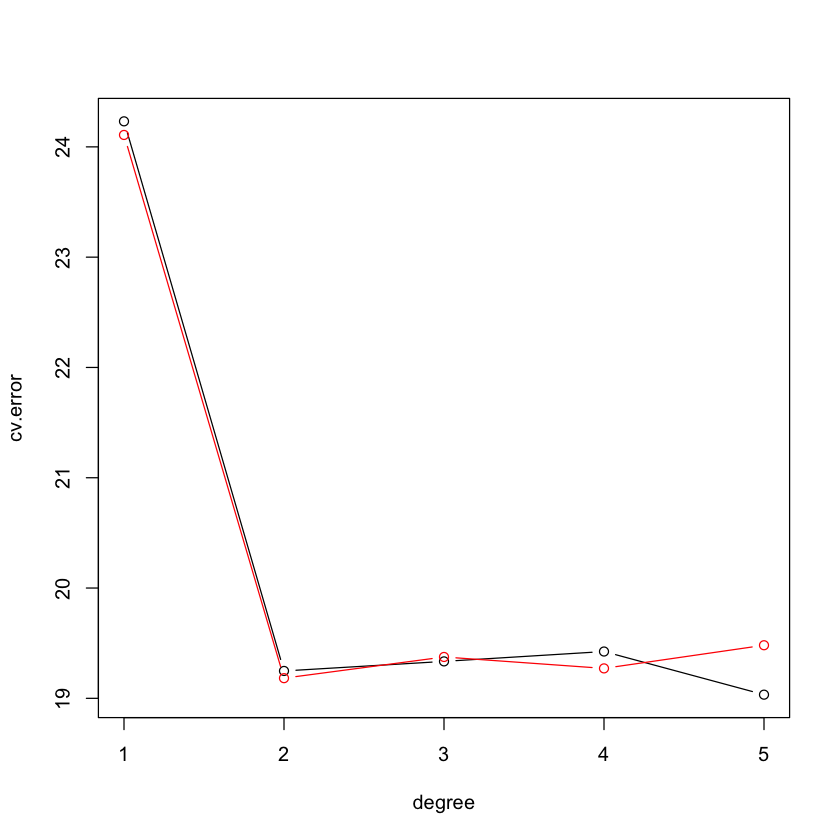

In [14]:
cv.error10 = rep(0, 5)
degree = 1:5
for(d in degree){
    glm.fit = glm(mpg ~ poly(horsepower, d), data=Auto)
    cv.error10[d] = cv.glm(Auto, glm.fit, K=10)$delta[1]
}

plot(degree, cv.error, type="b", col="black")
lines(degree, cv.error10, type="b", col = "red")

# Bootstrap
#### Minimizing the investment risk

Let $x$ & $y$ be two assets, $\alpha$ the amount to invest in $x$ then, it can be shown, that the $\alpha$ wich minimizes the risk is given by:

$$
    \alpha = \frac{\mathbb{V}(y) - \sigma_{x,y}}{\mathbb{V}(x) + \mathbb{V}(y) - 2\sigma_{x,y}}
$$

where:
* $\mathbb{V}$ is the variance
* $\sigma_{x,y}$ is the co-variance of $x$ and $y$

We want to find out what is the sampling variability of $\alpha$. i.e. what is its *standard error*?

In [15]:
alpha = function(x, y){
    vx = var(x)
    vy = var(y)
    cxy = cov(x, y)
    (vy - cxy)/(vx + vy - 2*cxy)
}

alpha(Portfolio$X, Portfolio$Y)

[1] 0.5758321

In [27]:
alpha.fn = function(data, index){
    with(data[index,], alpha(X,Y))
}

set.seed(1)
# What the Bootstrap will do over and over.
# Here we are only doing it once
alpha.fn(Portfolio, sample(1:100, 100, replace=TRUE))

[1] 0.5963833

In [28]:
boot.out = boot(Portfolio, alpha.fn, R=1000)
boot.out


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Portfolio, statistic = alpha.fn, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.5758321 -7.315422e-05  0.08861826

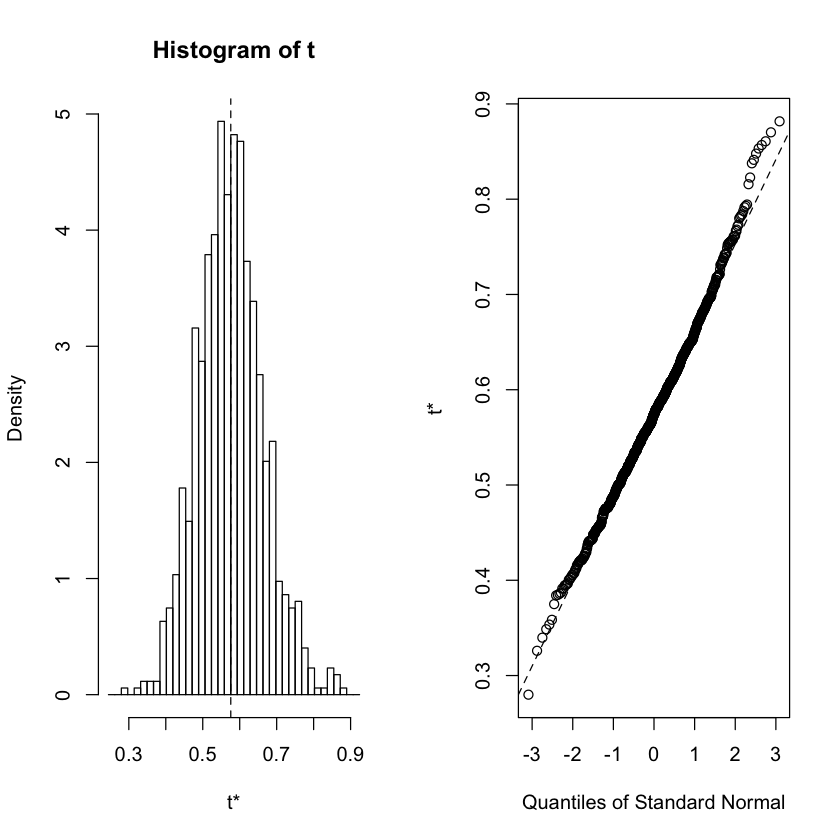

In [29]:
plot(boot.out)

# Exercises

1) Download the file 5.R.RData and load it into R using load("5.R.RData"). Consider the linear regression model of y on X1 and X2. What is the standard error for $\beta_1$?

In [6]:
load("5.R.RData")
dat.lm = lm(y ~ X1 + X2, data=Xy)

summary(dat.lm)


Call:
lm(formula = y ~ X1 + X2, data = Xy)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.44171 -0.25468 -0.01736  0.33081  1.45860 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.26583    0.01988  13.372  < 2e-16 ***
X1           0.14533    0.02593   5.604 2.71e-08 ***
X2           0.31337    0.02923  10.722  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5451 on 997 degrees of freedom
Multiple R-squared:  0.1171,	Adjusted R-squared:  0.1154 
F-statistic: 66.14 on 2 and 997 DF,  p-value: < 2.2e-16


2) plot the data using ```matplot(Xy,type="l")```. Which of the following do you think is most likely given what you see?

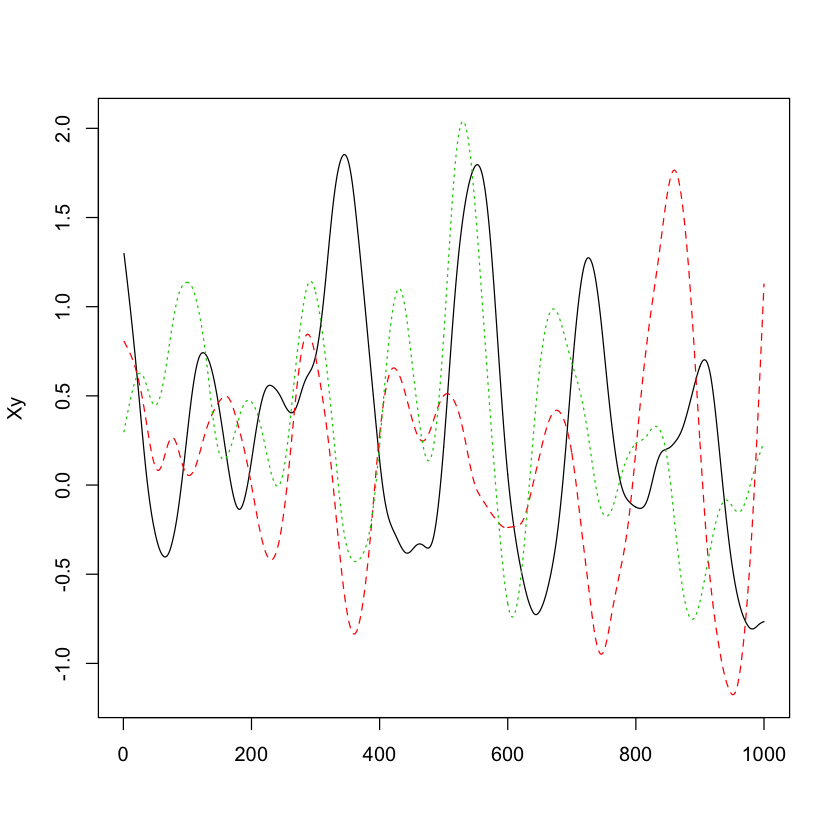

In [7]:
matplot(Xy, type="l")

3) Use the (standard) bootstrap to estimate $s.e.(\hat{\beta_1})$. To within 10%, what do you get?

In [39]:
beta1_est = function(data, index){
    # Getting the sample data from an index
    subsample = data[index,]
    # Fit a linear model using the subsample
    boot_fit = lm(y~X1+X2, data=subsample)
    # Return the parameter
    boot_fit$coefficients[2]
}

n = nrow(Xy)
# Fitting one instance of the bootrap
beta1_est(Xy, sample(1:n, n, replace=TRUE))

X1 
0.1323756

In [43]:
boot.beta1 = boot(data=Xy, statistic=beta1_est, R=1000)
boot.beta1


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = Xy, statistic = beta1_est, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.1453263 -0.0002883762  0.02906647

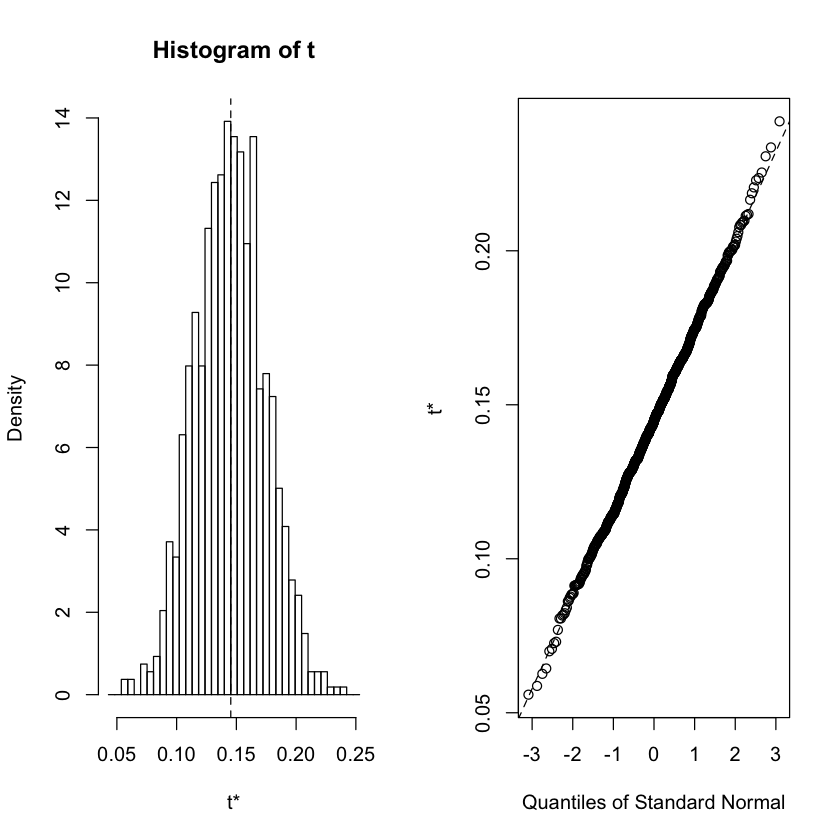

In [46]:
plot(boot.beta1)

4) use the block bootstrap to estimate $s.e. \hat{\beta_1}$. Use blocks of 100 contiguous observations, and resample ten whole blocks with replacement then paste them together to construct each bootstrap time series. For example, one of your bootstrap resamples could be:

```new.rows = c(101:200, 401:500, 101:200, 901:1000, 301:400, 1:100, 1:100, 801:900, 201:300, 701:800)```

```new.Xy = Xy[new.rows, ]```

To within 10%, what do you get?

In [120]:
# Where the estimated coefficients will be stored using the block bootstrap
beta1_hats = vector()

get_block_index = function(){
    # Return 1000 indices to sample from using 10 blocks of 100 from 1->901
    
    block_obs = sample(1:901, 10, replace=TRUE)
    subsample_index = vector()
    for(block in block_obs){
        subsample_index = append(subsample_index, block:(block+99))
    }
    
    subsample_index
}

# Perform block bootstrap 1000 times
for(i in 1:1000){
    subsample.Xy = Xy[get_block_index(), ]
    beta1_hat = lm(y ~ X1+X2, data=subsample.Xy)$coefficients[2]
    beta1_hats[i] = beta1_hat
}

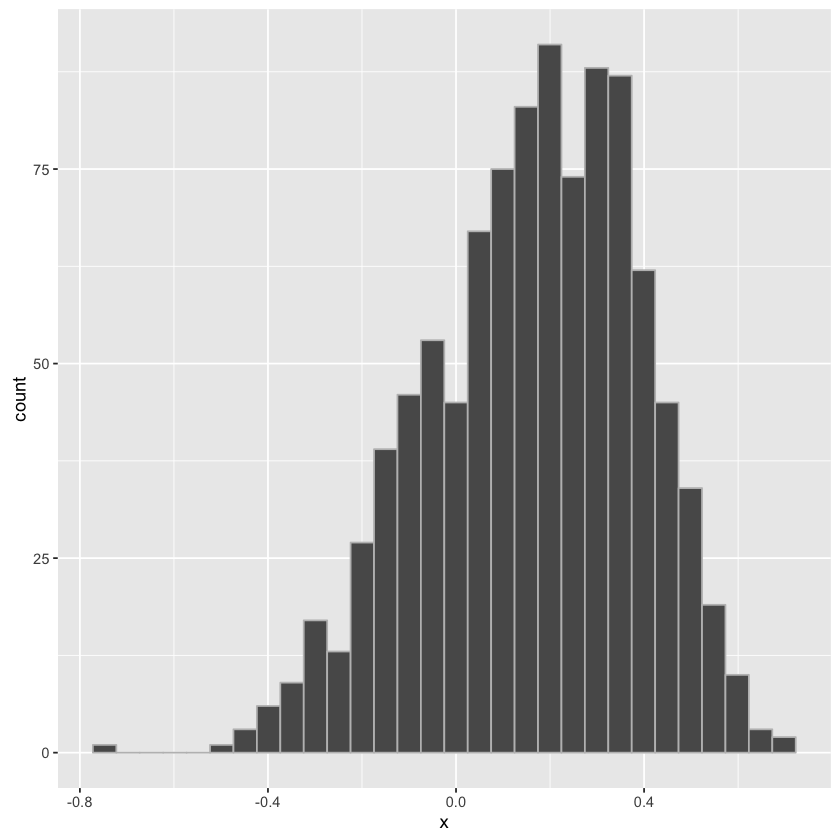

In [136]:
data.frame(x=beta1_hats) %>%
    ggplot(aes(x=x)) + geom_histogram(bins=30, color="gray")

In [137]:
mean(beta1_hats)

[1] 0.1636425

For bootstrap subsamples ${\{Z^{*r}\}_{r=1}^{B}}$ with estimates ${\{\hat{\alpha}^{*r}\}_{r=1}^{B}}$, the bootstrap estimate for standard errors is given by:

$$
    SE_B(\hat{\alpha}) = \sqrt{\frac{1}{B-1}\sum_{r=1}^B \left(\hat{\alpha}^{*r} - \frac{1}{B}\sum_{r'=1}^{B}\hat{\alpha}^{*r'}\right)^2}
$$

In [142]:
B = length(beta1_hats)
mean_term = sum(beta1_hats) / B

SE_beta1 = sqrt(sum((beta1_hats - mean_term)^2) / (B - 1))
SE_beta1

[1] 0.2232876